# Name(s): Alexa Aguilar Izquierdo and Antonio Oldair Jimenez

# Assignment 5: Clustering

In this assignment we'll be looking at three popular types of clustering algorithms -- K-means clustering, Density-based clustering, and Hierarchical clustering. We'll also look at some measures of cluster quality like cohesion, separation and silhoutte coefficient.

## Part 1: Implement K-means Clustering

In k-means clustering you are given a dataset and a hyperparameter, k, specifying the number of desired clusters. The objective function of k-means is to minimize the sum of squared error (SSE) of the resulting clusters. Unfortunately, this is an NP Hard problem. In this assignment we'll be implementing the iterative k-means algorithm that guarantees convergence, but does not guarantee the globally optimal solution.

In [29]:
# Some headers
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand
from numpy import square, sqrt
from pandas import DataFrame
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from scipy.spatial.distance import pdist

In [30]:
# Enable inline mode for matplotlib so that IPython displays graphs.
%matplotlib inline

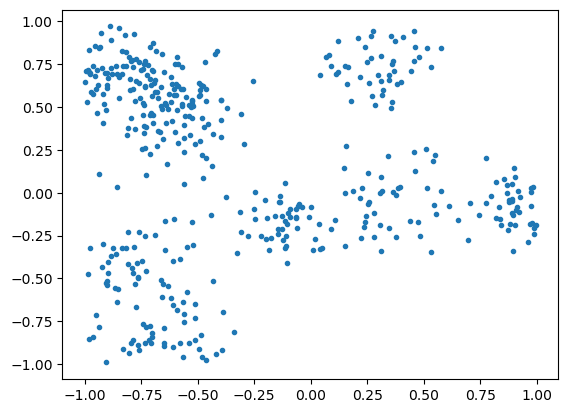

In [31]:
# get data from text file
data = np.genfromtxt("data_kmeans.csv", delimiter=",")
plt.scatter(data[:,0],data[:,1], marker='.')

Q1. Implement the function `generate_clusters` that returns clusters, given the cluster centroids (`mu`) and the dataset (`data`). Each datapoint needs to be associated to the closest cluster centroid.

In [32]:
def generate_clusters(data, mu):
    clusters = [[centroid] for centroid in mu]
    for point in data:
        closest_cluster = 0
        closest_cluster_dist = np.linalg.norm(point -  mu[0])
        for index, centroid in enumerate(mu): 
            if index != 0:# skip first as it was used to intialize values
                dist = np.linalg.norm(point - centroid)
                if dist < closest_cluster_dist:
                    closest_cluster_dist = dist
                    closest_cluster = index
        clusters[closest_cluster].append(point)    
    clusters = [np.array(cluster) for cluster in clusters]
    return np.array(clusters, dtype=object)
# clusters = generate_clusters(data, np.array([np.array([-1,-1]), np.array([1,1])]))

Q2. Implement the function `recompute_centroids` that returns the centroids given a set of input clusters.

In [33]:
def recompute_centroids(clusters):
    # might need to add something in the case that no points were added to a cluster
    new_centroids = []
    for cluster in clusters:
        new_centroids.append(np.mean(cluster, axis=0))
    new_centroids = np.array(new_centroids)
    return np.array(new_centroids)
# print(recompute_centroids(clusters))

Q3. Implement the function `check_convergence` that checks if the termination condition of the k-means algorithm has been reached, i.e. whether the previous centroids are the same as the new centroids. 

In [34]:
def check_convergence(mu, previous_mu):
    if np.array_equal(mu, previous_mu):
        return True
    else:
        return False

Q4. Implement the function `k_means_clustering` that returns k clusters along with their centroids, given the input dataset and the desired number of clusters (`k`).

IMPORTANT: The actual k-means clustering algorithm starts by selecting k random centroids. For the purposes of this assignment, always choose the first k datapoints in the dataset to be your initial centroids.

In [35]:
def k_means_clustering(data, k):
    # init
    mu = data[0:k]
    clusters = generate_clusters(data, mu)
    new_mu = recompute_centroids(clusters)
    while check_convergence(new_mu,mu) == False:
        mu = new_mu
        clusters = generate_clusters(data, mu)
        new_mu = recompute_centroids(clusters)

    return(new_mu, clusters)

Q5. Cluster the data using `k_means_clustering` with `k = 5`. Display the clusters using `plt.scatter` and mark each cluster with a different color. 

Also calculate the cohesion and separation for the resulting clustering.

Cohesion: 124.31543145451013
Separation: 312.5951110581026


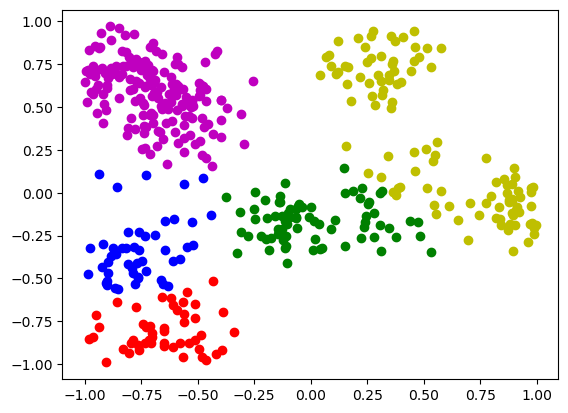

In [36]:
def calc_cohesion_separation(mu, clusters):
    cohesion = 0
    separation = 0
    data_centroid = np.mean(data, axis=0)
    for index, cluster in enumerate(clusters):
        for point in cluster:
            cohesion += np.linalg.norm(point - mu[index])
        separation += np.linalg.norm(data_centroid - mu[index]) * len(cluster)
    return cohesion, separation


mu, clusters = k_means_clustering(data, 5) 
cohesion, separation = calc_cohesion_separation(mu,clusters)
colors = ["r", "g", "b", "y", "m", "c", "orange", "purple", "brown", "pink"]
for index, cluster in enumerate(clusters):
    plt.scatter(cluster[:, 0], cluster[:, 1], c=colors[index])
print("Cohesion: " + str(cohesion))
print("Separation: " + str(separation))




Q6. Find the best k for this dataset by plotting SSE vs k for k = 1-10. Based on your plot, which value of k would you choose and why? (Answer as a comment.)

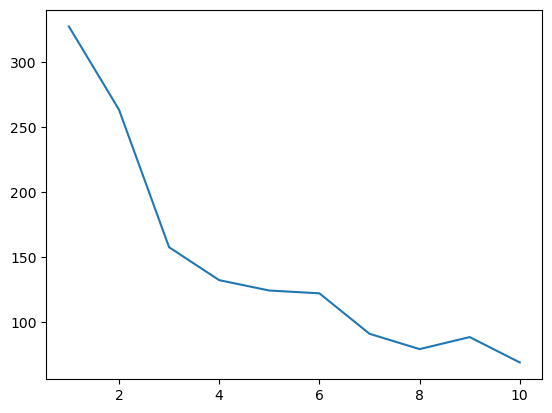

In [37]:
SSE_values = []
for k in range(1,11):
    mu, clusters = k_means_clustering(data,k)
    cohesion, _= calc_cohesion_separation(mu,clusters)
    SSE_values.append(cohesion)
k = np.arange(1, 11)
plt.plot(k, SSE_values)
# It depends on how many clusters we want. 3 serves as a good k value as it is the the last k value which largely reduces the SSE. It does the best job at not overfitting and underfitting. The best k value, however, could depend on the use case. 7 serves as a good alternative if you wish to have more clusters. 

## Part 2: Implement DBSCAN

For this part you'll be implementing DBSCAN, one of the most popular density-based clustering algorithms.

<class 'numpy.ndarray'>


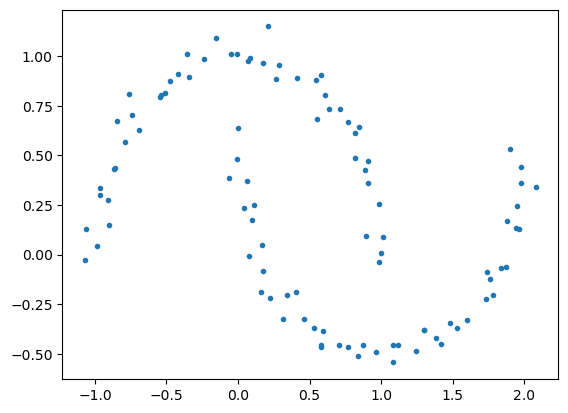

In [38]:
# get data from text file
data = np.genfromtxt("data_dbscan.csv", delimiter=",")
plt.scatter(data[:,0],data[:,1], marker='.')
print(type(data))

Q7. First, run your `k_means_clustering` with `k = 2` on this dataset and display the output clusters. Make sure  different clusters are marked with different colors. What do you observe? (Answer as a comment.)

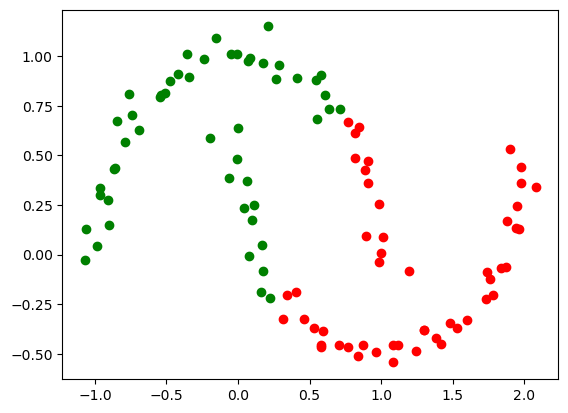

In [39]:
# your code goes here
mu, clusters = k_means_clustering(data, k=2)
for index, cluster in enumerate(clusters):
    plt.scatter(cluster[:, 0], cluster[:, 1], c=colors[index])


Q8. Implement the DBSCAN algorithm and display the output clusters. 

There is a  pseudocode version of the DBSCAN algorithm on [Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) that you are welcome to follow. 

(If you are not familiar with the `continue` statement, look [here](https://www.tutorialspoint.com/python/python_loop_control.htm) for what it does - it may not do what you think!)

Run your DBSCAN clustering on the data with eps = 0.28 and minPts = 8. Plot the resulting clusters with each cluster, and noise, indicated by different colors. 

{1, 2, 'noise'}


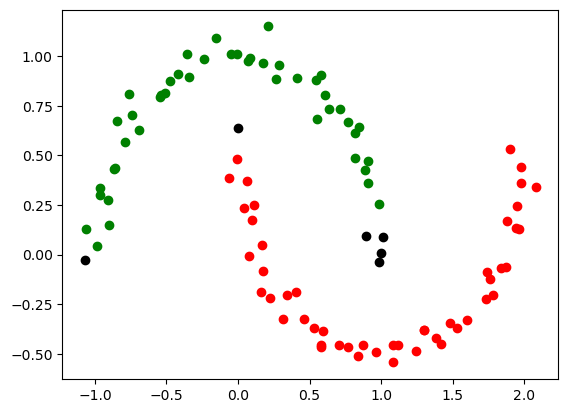

In [40]:
# your code goes here
def dbscan(data, eps, minpts):
  counter = 0
  labels = [None for i in data]

  for index, point in enumerate(data):
    if labels[index] is not None:
      continue
    else:
      neighbors = RangeQuery(data, point, eps)
      
      if len(neighbors) < minpts:
        labels[index] = 'noise'
        continue
      else:
        counter += 1
        labels[index] = counter # core point
        seedset = neighbors.copy()
        for q in seedset:
          if labels[q] == 'noise':
            labels[q] = counter # border point
          elif labels[q] is not None:
            continue
          labels[q] = counter # core point
          neighbors = RangeQuery(data, data[q], eps)
          if len(neighbors) >= minpts:
            for n in neighbors:
              if n not in seedset:
                seedset.extend(neighbors)
  return labels

def RangeQuery(data, q, eps):
  neighbors = []
  for index, point in enumerate(data):
    if np.linalg.norm(q - point) <= eps:
      neighbors.append(index)
  return neighbors

labels = dbscan(data, 0.28, 8)
print(set(labels))
for index, point in enumerate(data):
    if labels[index] == 'noise':
      color = 'black'
    else:
      color = colors[labels[index]-1]
      label = f'Cluster {labels[index]}'
    plt.scatter(point[0], point[1], c=color)


## Part 3: Clustering with scikit-learn and scipy

#### Data

For this part of the assigment you'll be working with the Epileptic Seizure Recognition Data Set developed at Rochester Institute of Technology. In this data set each row is a sample of the EEG recording at a different point in time. The dataset contains 179 columns, the first 178 are the EEG features while the last column represents the label y {1, 2, 3, 4, 5}. All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have an epileptic seizure. The class labels will not be used for our *unsupervised* clustering - they will just be used for plotting the data. The only change that was made to the original dataset was removing the first column, which contained the row indexes. You can find additional information about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition).

In [41]:
# Reading the Epileptic Seizure Data Set
dataset = pd.read_csv("data_seizure_edited.csv", header = 0)
print(dataset.shape)

#split the dataset into features and labels
labels = dataset['y']
raw_data = dataset.drop('y', axis = 1)

dataset.head()

(11500, 179)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


#### Data scaling & dimensionality reduction with PCA
Both K-means and DBSCAN break down in high dimensions, as distance (and thus density) become less meaningful in high dimensions. So, before we run either of these clustering algorithms, we want to reduce the dimensionality of our dataset. Recall that it is critical to scale your data prior to running PCA. 

Q9. 
* Use `sklearn.preprocessing.StandardScaler` to standardize the dataset’s features (mean = 0 and variance = 1). Only standardize the the features, not the class labels! This will be required for running the principal component analysis (PCA) dimensionality reduction. Note that `StandardScaler` returns a numpy array.
* Use `sklearn.decomposition.PCA` to perform PCA on the data.
* Set `n_components` to 0.95 and `svd_solver` to 'full', so that the PCA will reduce the number of dimensions to however many are necessary to retain 95% of the variance. 
* Use `fit_transform` to perform the dimensionality reduction. 
* Note that `fit_transform` returns a numpy array. Put your transformed data back into a Pandas DataFrame by doing something like this (subsitute your variable names): `data = DataFrame(pca_data)`.
* Show the head of the resulting DataFrame (and make sure the dimensionality has actually been reduced).

In [42]:
# your code goes here
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler(with_mean=0, with_std=1).fit_transform(dataset[dataset.columns[:-1]])
pca = PCA(0.95, svd_solver='full').fit_transform(scaler)
data = DataFrame(pca)
data.head()

/Users/alexa/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,-0.137475,-1.146419,0.836893,-0.071085,-0.177048,-0.825731,0.777044,0.337638,2.744494,-0.734679,...,0.994987,-2.154933,1.053161,-0.090869,0.254414,-0.225816,-1.055100,-0.320229,0.195361,-0.102763
1,-1.703794,-3.643195,6.153822,8.033432,4.549536,5.892971,3.758370,-5.804916,4.187441,11.192247,...,-5.864539,-7.613729,5.082526,-2.786232,1.832683,2.158849,2.594621,-0.218890,0.437192,-3.813345
2,0.495650,-0.261660,0.931210,-0.663789,1.587618,-1.604942,-0.880830,-1.591959,-0.400873,-1.435073,...,0.124686,0.027333,0.946955,0.827331,-0.611872,0.389295,-0.490630,0.015729,-0.180175,0.048221
3,-0.174219,0.249557,-0.073646,-0.108047,1.615415,-3.136337,-0.559638,-3.032901,-0.222729,-1.465921,...,-0.322617,0.162047,-0.002372,-0.053858,-0.205829,-0.160254,0.048781,0.088260,0.201175,0.139328
4,-0.239163,0.117304,0.486502,-0.530629,0.187739,-0.371186,-0.045861,0.481596,-0.094907,0.541482,...,-0.360548,-0.399276,0.100645,-0.334393,0.155918,-0.114335,0.262911,-0.916693,0.658297,-0.122812


Q10. You are provided code here to plot the data. This code randomly samples 300 rows from the entire dataset, then uses `sklearn.manifold.MDS` to project the data onto two dimensions, and plots it on a scatter plot. The points will be marked with appropriate colors based on their labels. This is the only time labels will be used.
* Pass your dataset (that has been reduced in dimensions from Q9) and the labels into this scatter function. Verify that the plot looks like 2 clusters: an inner cluster (non-seizure patients, labels 2-5, will be blue/green/yellow), and an outer cluster (seizure patients, label 1, will be purple).

/Users/alexa/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


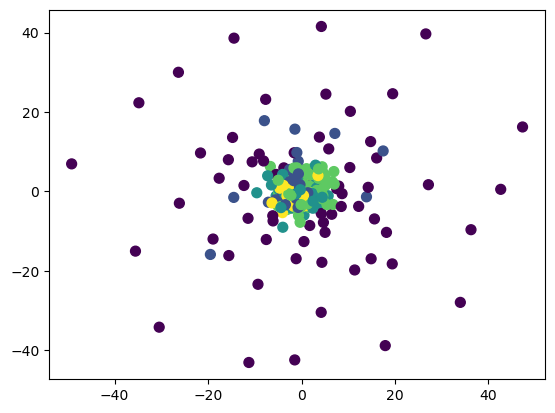

In [43]:
# do not change this plotting function!
def scatter(data, labels, numPoints = 300):

    numEntries = data.shape[0]
    start = random.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data)
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

# your code goes here
scatter(data, pd.Series(labels))

#### Clustering with DBSCAN

Recall that for DBSCAN, we need to select an Eps and a MinPts. If we choose MinPts to be 4, then Eps can be selected by plotting the distance of every point to its 4th nearest neighbor and finding the "bend" in the graph. 

Q11. Find the optimal Eps for this dataset by plotting the distances of every point to its 4th nearest neighbor.
* Use `sklearn.neighbors.NearestNeighbors` with `n_neighbors=4`. Call `fit` on your data.
* Use the `kneighbors` method to find the distance of each point to its 4th nearest neighbor. Note that `kneighbors` returns two values. The first return value is a matrix of distances from each point to its k nearest neighbors. 

* Sklearn considers the distance from the point to itself as the closest neighbor (a distance of 0), then if the point is a distance of 2.5 away from its second nearest neighbor, a distance of 3.7 away from its third nearest neighbor, and a distance of 4.2 away from its fourth nearest neighbor, the row in the distance matrix for this point would look like: `[0, 2.5, 3.7, 4.2]`, indicating that 4.2 is the distance from this point to it's 4th nearest neighbor. 

* Plot the distance of every point to its 4th nearest neighbor. Be sure to sort the distances before you plot them. You can use `plt.plot(distances)` then `plt.show()` to plot them. 
* Use the plot to determine the best Eps for this dataset (just eyeball it).

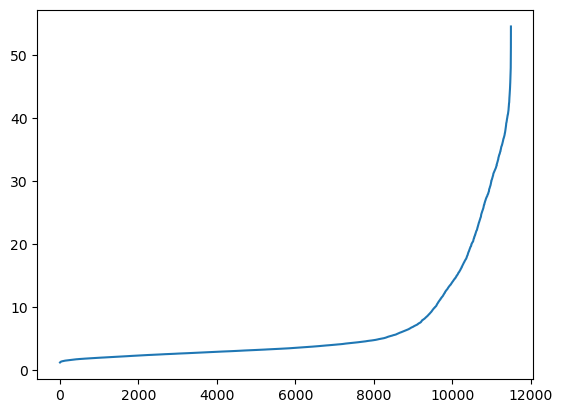

In [44]:
# your code goes here
from sklearn.neighbors import NearestNeighbors
matrix, _ = NearestNeighbors(n_neighbors=4).fit(data).kneighbors()
distances = sorted(matrix[:,3])
plt.plot(distances)
plt.show()
# choose eps 7.5

Q12. 
* Using MinPts=4 and Eps=the distance you determined from Q11, cluster the data using `sklearn.cluster.DBSCAN`. Call `fit_predict` on your data and store the return value (the predicted cluster label for each data point). Note that the returned type is a numpy array. 
* Use the provided `scatter` function (Q10) to plot the resulting clusters. You will need to convert the numpy array of predicted labels to a `Series` in order to pass it in to `scatter`.

[ 0 -1  0 ...  0  0  0]


/Users/alexa/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


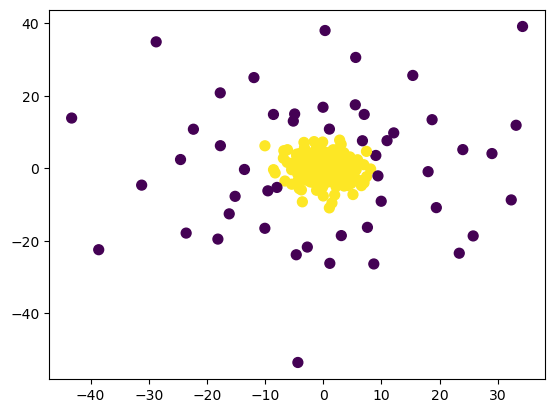

In [45]:
# your code goes here
from sklearn.cluster import DBSCAN 
clustering = DBSCAN(eps=7.5, min_samples=4).fit_predict(data)
print(clustering)
scatter(data, pd.Series(clustering))

#### Clustering with K-means

Q13. 
* Use `sklearn.cluster.KMeans` to cluster this data using k-means. Try values of k from 2 to 5. You will need to call `fit_predict` on your data and store the return value (the predicted cluster label for each data point). Note that the returned type is a numpy array. 
* Use `sklearn.metrics.silhouette_score` to determine an appropriate number of clusters for this dataset. 
* Use the provided `scatter` function (Q10) to plot the clustering that resulted in the best silhouette score. Note that you will need to cast the predicted cluster labels (a numpy array) to a Series in order to pass it in to `scatter`.

/Users/alexa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alexa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alexa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alexa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

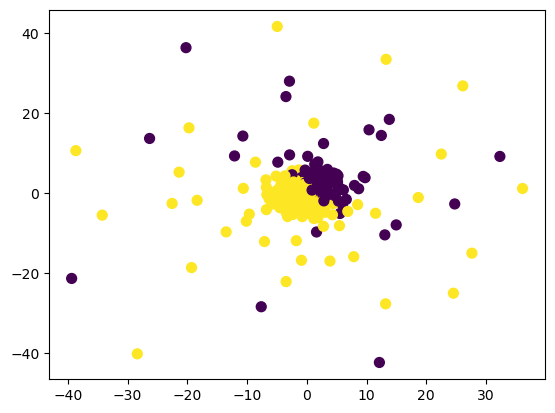

In [46]:
# your code goes here
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score

max, score_max = 0, 0
for i in range(2,6):
  clusters = KMeans(i).fit_predict(data)
  score = silhouette_score(data, clusters)
  if score > max:
    max = i
    score_max = score
    best_clusters = clusters

scatter(data, pd.Series(best_clusters))


Q14. What do you observe about the results of DBSCAN vs the results of k-means? Answer as a comment.

In [47]:
'''
DBSCAN was better at clustering the data given the nature of what we were trying to identify, the center cluster.
Due to the center cluser having higher density DBSCAN performed well in clustering it. K-means clusters using centroids in N-dimensions. Given that the data overlaps K means clustering is not a good method for our objective.'''

'\nDBSCAN was better at identifying the center cluster due to its higher density. K-means clusters using centroids, and it is less appropriate for this data set.\n'

#### Hierarchical Clustering

For hierarchical clustering (Q15 and Q16), you'll work with a sample of only 115 datapoints. The function to downsample the dataset is provided here for you.

In [48]:
# Do not change the code in this cell
# stratified sampling of the data
def downsample_data(data, labels):
    downData = None
    downLabels = None

    kfold = StratifiedKFold(n_splits = 100, shuffle = False)
    for throwAway_index, subsample_index in kfold.split(data, labels):
        downData = data.iloc[subsample_index]
        downLabels = labels.iloc[subsample_index]
        break
    
    print(downData.shape)
    return downData

Q15. Use Scipy's hierarchical clustering (`scipy.cluster.hierarchy`) to cluster the data using different linkage methods. **Make sure you are using a down-sampled dataset by passing your dataset into the provided downsample_data() function.**

* Try all of these linkage methods: `single`, `complete`, `average`, `centroid`, `ward`
* Note that the return value of the clustering is a linkage matrix (a cophenetic distance matrix)

* Calculate the CPCC of each linkage method to determine which method worked best. Use `scipy.cluster.hierarchy.cophenet` for this. You'll pass in the linkage matrix from the clustering, and a proximity matrix that contains the actual distances between each point, which you can get by using `scipy.spatial.distance.pdist`. 

In [49]:
# Make sure to pass your dataset into downsample_data() 
# and use the resulting smaller dataset for hierachical clustering

# Pass the down-sampled dataset into pdist to get your proximity matrix for calculating CPCC
downdata = downsample_data(data, labels)
proximity_matrix = pdist(downdata)

# the rest of your code goes here
from scipy.cluster import hierarchy
methods = ['single', 'complete', 'average', 'centroid', 'ward']
for method in methods:
  clustering = hierarchy.linkage(downdata, method)
  cpcc, _ = hierarchy.cophenet(clustering, proximity_matrix)
  print(method, cpcc)


(115, 39)
single 0.9889267562252902
complete 0.9365460775733224
average 0.9908940882254501
centroid 0.9910633636860081
ward 0.916689787997314


Q16. Using the best linkage method that you found in Q7, plot the dendrogram with `scipy.cluster.hierarchy.dendrogram`. (The labels on the x-axis will be too small to read - that is ok!)

{'icoord': [[205.0, 205.0, 215.0, 215.0],
  [295.0, 295.0, 305.0, 305.0],
  [315.0, 315.0, 325.0, 325.0],
  [405.0, 405.0, 415.0, 415.0],
  [465.0, 465.0, 475.0, 475.0],
  [625.0, 625.0, 635.0, 635.0],
  [615.0, 615.0, 630.0, 630.0],
  [835.0, 835.0, 845.0, 845.0],
  [825.0, 825.0, 840.0, 840.0],
  [815.0, 815.0, 832.5, 832.5],
  [805.0, 805.0, 823.75, 823.75],
  [995.0, 995.0, 1005.0, 1005.0],
  [985.0, 985.0, 1000.0, 1000.0],
  [975.0, 975.0, 992.5, 992.5],
  [965.0, 965.0, 983.75, 983.75],
  [955.0, 955.0, 974.375, 974.375],
  [945.0, 945.0, 964.6875, 964.6875],
  [935.0, 935.0, 954.84375, 954.84375],
  [925.0, 925.0, 944.921875, 944.921875],
  [915.0, 915.0, 934.9609375, 934.9609375],
  [905.0, 905.0, 924.98046875, 924.98046875],
  [895.0, 895.0, 914.990234375, 914.990234375],
  [885.0, 885.0, 904.9951171875, 904.9951171875],
  [875.0, 875.0, 894.99755859375, 894.99755859375],
  [865.0, 865.0, 884.998779296875, 884.998779296875],
  [855.0, 855.0, 874.9993896484375, 874.999389648437

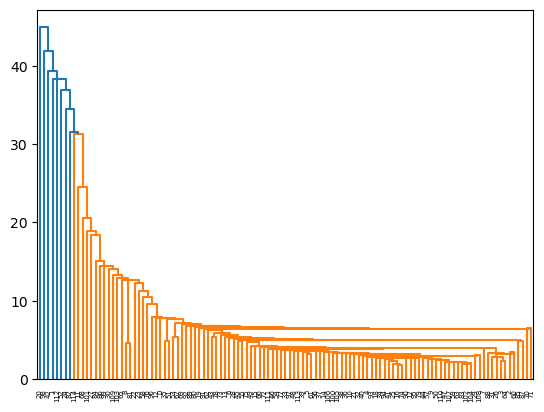

In [50]:
# your code goes here
hierarchy.dendrogram(hierarchy.linkage(downdata, 'centroid'))

#### Anomaly Detection (AD)

Anomaly detection (AD) algorithms can be broadly classified into 3 classes:
- Supervised AD (labels available for both normal data and anomalies)
- Semi-supervised AD, also called Novelty Detection (only normal data is available to train on)
- Unsupervised AD, also called Outlier Detection (no labels are provided)

In this part you'll experiment with 4 datasets and compare 4 different outlier detection (Unsupervised AD) methods.

In [51]:
# loading the datasets
filenames = ['data1.csv', 'data2.csv', 'data3.csv', 'data4.csv']
datasets = [np.loadtxt(fname, delimiter=',') for fname in filenames]
for fname, data in zip(filenames, datasets):
    print (fname, data.shape)

data1.csv (445, 2)
data2.csv (314, 2)
data3.csv (419, 2)
data4.csv (441, 2)


Q17. Detect the outliers in all 4 datasets using the following algorithms:
- `sklearn.covariance.EllipticEnvelope` - a statistical-based AD method
- `sklearn.ensemble.IsolationForest` - an isolation-based AD method
- `sklearn.neighbors.LocalOutlierFactor` - a density-based AD method
- `sklearn.svm.OneClassSVM` - a model-based AD method

Create scatterplots that show the outliers detected in each dataset with each method. (16 plots in total.)

The following plotting function is provided for you. You should pass in a list of y_pred values corresponding to all 16 of your plots. 

In order for this plotting function to work correctly, the order of your list should be: EllipticEnvelope on dataset1, IsolationForest on dataset1, LocalOutlierFactor on dataset1, OneClassSVM on dataset1, EllipticEnvelope on ds2, IsolationForest on ds2, LocalOutlierFactor on ds2, OneClassSVM on ds2, EE on ds3, IF on ds3, LOF on ds3, SVM on ds3, EE on ds4, IF on ds4, LOF on ds4, SVM on ds4.

In [52]:
# Do not change the code in this cell!
# Create all 16 anomaly detection plots
def plot_all(y_preds):
    
    print("len(y_preds):", len(y_preds))
    
    names = ['Robust Covariance', 'Isolation Forest', 'Local Outlier Factor', 'One-Class SVM']
    plt.figure(figsize=(len(names) * 2 + 3, 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
    plot_num = 1
    
    for i_dataset in range(len(datasets)):
        for j_algorithm in range(len(names)):
            
            plt.subplot(len(datasets), len(names), plot_num)
            if i_dataset == 0:
                plt.title(names[j_algorithm], size=18)

            colors = np.array(['#377eb8', '#ff7f00'])
            plt.scatter(datasets[i_dataset][:, 0], datasets[i_dataset][:, 1], 
                        s=10, color=colors[(y_preds[plot_num-1] + 1) // 2])

            plt.xlim(-7, 7)
            plt.ylim(-7, 7)
            plt.xticks(())
            plt.yticks(())
            
            plot_num += 1

    plt.show()

Directions:
* Use a `contamination` (or `nu` for `OneClassSVM`) of 0.25.
* For the `OneClassSVM` use `rbf` kernel.
* NOTE: To preform AD in an unsupervised way, you will pass the same dataset into `fit` and `predict.`

Some code is provided here to get you started.

len(y_preds): 64


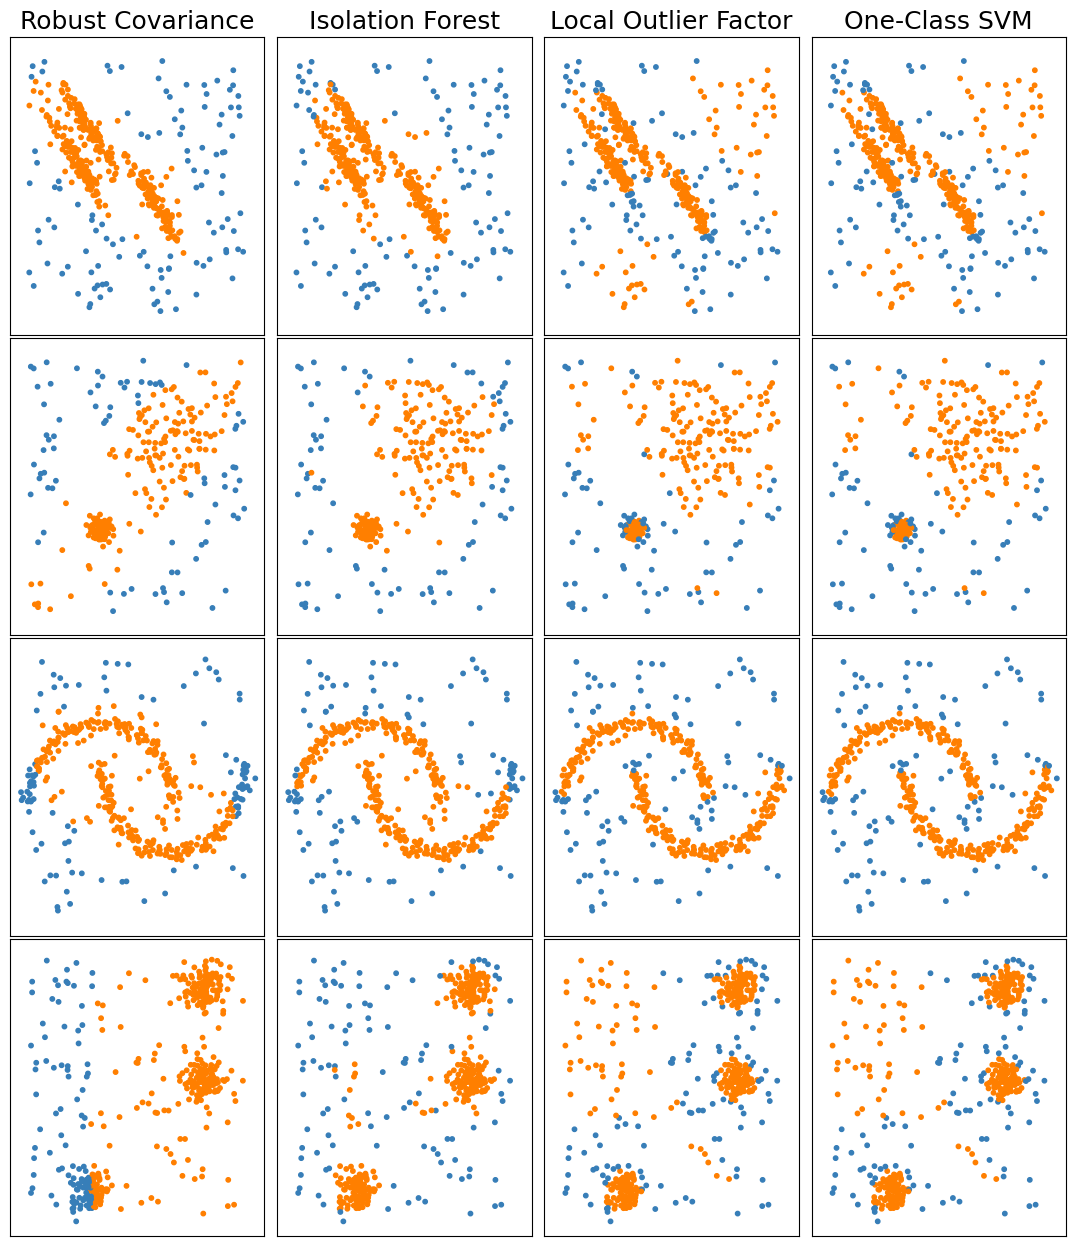

In [53]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


outliers_fraction = 0.25

#this will be your list of 16 plots
y_pred_list = list()

#for each of the 4 datasets
for X in datasets:
    for X in datasets:
        #apply EllipticEnvelope AD
        #append resulting y_pred to y_pred_list
        ee = EllipticEnvelope(contamination=outliers_fraction)
        y_pred=ee.fit_predict(X)
        y_pred_list.append(y_pred)
        #apply IsolationForest AD
        #append resulting y_pred to y_pred_list
        iF = IsolationForest(contamination=outliers_fraction)
        y_pred=iF.fit_predict(X)
        y_pred_list.append(y_pred)
        #apply LocalOutlierFactor AD
        #append resulting y_pred to y_pred_list
        LOF = LocalOutlierFactor(contamination=outliers_fraction)
        y_pred=LOF.fit_predict(X)
        y_pred_list.append(y_pred)
        #apply OneClassSVM AD
        #append resulting y_pred to y_pred_list
        OC_SVM = OneClassSVM(nu=outliers_fraction, kernel='rbf')
        y_pred=LOF.fit_predict(X)
        y_pred_list.append(y_pred)

plot_all(y_pred_list)